# Определение перспективного тарифа для телеком компании

Необходимо произвести анализ «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше. 

Таблица описания тарифов:

|Услуга             |Тариф «Смарт»  |Тариф «Ультра   |
| ----------------- | ------------- | -------------- |
|Ежемесячная плата  |550 рублей     |1950 рублей     |
|Включено:          |               |                |
|Минут разговора    |500            |3000            |
|Сообщений          |50             |1000            |
|Интернет-трафика   |15 Гб          |30 Гб           |
|Сверх:             |               |                |
|Минута разговора*  |3 рубля        |1 рубль         |
|Сообщение          |3 рубля        |1 рубль         |
|1 Гб               |200 рублей     |150 рублей      |
*(округляет вверх)

<div class="alert alert-block alert-success">
Комментарий ревьюера v. 1:
    
Молодец, что кратко описала цель проекта и тарифы для анализа.
</div>

### Служебные функци для быстрого использования

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
from scipy import stats as st
import seaborn as sns

def myhist(b, x,xl,g, r):
    x.hist(bins=b, range=r)
    plt.title(f'Гистограмма {g}: ' + xl)
    plt.xlabel(xl)
    plt.ylabel("Частота")


    

In [24]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

<div class="alert alert-block alert-success">
Комментарий ревьюера v. 1:
    
Отличная идея использовать отдельные функции для построения графиков :)
</div>

## Шаг 1. Изучение общей информацию

In [25]:
calls = pd.read_csv('/datasets/calls.csv',  sep=',' , decimal='.')
calls.name = 'calls'
internet = pd.read_csv('/datasets/internet.csv',  sep=',' , decimal='.')
internet.name = 'internet'
messages = pd.read_csv('/datasets/messages.csv',  sep=',' , decimal='.')
messages.name = 'messages'
tariffs = pd.read_csv('/datasets/tariffs.csv',  sep=',' , decimal='.')
tariffs.name = 'tariffs'
users = pd.read_csv('/datasets/users.csv',  sep=',' , decimal='.')
users.name ='users'

In [26]:
df_list = [calls, internet, messages, tariffs, users]
for x in df_list:
    print('\n',x.name,'\n')
    x.info()



 calls 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

 internet 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

 messages 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

 tari

Вот название и значения колонок в этих таблицах <strike>слева направо</strike>:

<b>Таблица users (информация о пользователях):</b>

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

<b>Таблица calls (информация о звонках):</b>

* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

<b>Таблица messages (информация о сообщениях):</b>

* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

<b>Таблица internet (информация об интернет-сессиях):</b>

* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

<b>Таблица tariffs (информация о тарифах):</b>

* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101-й минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Вывод
Имеется 5 связанных между собою таблиц, в которых почти нет пропусков. Необходимо изучить таблицы, выполнив обработку данных для дальнейшего анализа, сделать  мега-таблицу для анализа.

## Шаг 2. Предобработка данных
### Дубликаты
Сначала удалим все дубликаты в таблицах, если они есть.

In [27]:
for x in df_list:
    print(f'таблица {x.name} длиной - {len(x)} до обработки')
    x.drop_duplicates(inplace = True) 
    print(f'после: {len(x)}')

таблица calls длиной - 202607 до обработки
после: 202607
таблица internet длиной - 149396 до обработки
после: 149396
таблица messages длиной - 123036 до обработки
после: 123036
таблица tariffs длиной - 2 до обработки
после: 2
таблица users длиной - 500 до обработки
после: 500


Дубликатов нет. Начнем смотреть более прицельно.
### users 

In [28]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Переведем  все даты в тип datetime64. Добавим столбец день и месяц подключения и отключения.

In [29]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

users['churn_day'] = pd.DatetimeIndex(users['churn_date']).month
users['churn_month'] = pd.DatetimeIndex(users['churn_date']).day

users['reg_day'] = pd.DatetimeIndex(users['churn_date']).month
users['reg_month'] = pd.DatetimeIndex(users['churn_date']).day

print(f"Диапозон наблюдений: \n подключения {users['reg_date'].min()} - {users['reg_date'].max()}; \n отключения {users['churn_date'].min()} - {users['churn_date'].max()}")

Диапозон наблюдений: 
 подключения 2018-01-01 00:00:00 - 2018-12-31 00:00:00; 
 отключения 2018-08-17 00:00:00 - 2018-12-30 00:00:00


<div class="alert alert-block alert-success">
Комментарий ревьюера v. 1:
    
Ок, данные к нужному типу приведены.
</div>

В таблицах отражены данные наблюдения за 500 подключениями. Поосмотрим на города:

In [30]:
users['city'].value_counts(dropna = False)

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Нижневартовск       1
Архангельск         1
Подольск            1
Химки               1
Иваново             1
Name: city, Length: 76, dtype: int64

Наблюдения ведутся по всей России. Но мы не сможем построить анализ по городу для одного человека. Поэтому оставим Москву, Санкт-Петербург и Другой:

In [31]:
users['city'] = users['city'].where(((users['city'] == 'Москва')|(users['city'] == 'Санкт-Петербург')), 'Другой')
users['city'].value_counts()

Другой             362
Москва              99
Санкт-Петербург     39
Name: city, dtype: int64

Соединим имя и фамилию, посмотрим, нет ли абонентов с одинаковыми полными именами.

In [32]:
users['full_name'] = users['last_name'] + ' ' + users['first_name']
users['full_name'].value_counts(dropna = False)

Бобылёв Альбин        1
Кондратов Радомир     1
Алешин Адам           1
Гаврилова Элеонора    1
Ёлчина Валерия        1
                     ..
Аракина Розалия       1
Галкин Рустэм         1
Суслов Онисим         1
Авраамова Лидия       1
Костин Исаак          1
Name: full_name, Length: 500, dtype: int64

Таких не имеется.

Добавим id , age, churn_date, city, reg_date, tariff в таблицу df

In [33]:
df = users[['user_id' , 'age', 'churn_date', 'city', 'reg_date', 'tariff']].rename({'user_id':'user_id','age':'age','churn_date':'churn_date','city':'city','reg_date':'reg_date','tariff':'tariff'}, axis=1)

### calls

In [34]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Сразу бросается в глаза 0-ая длительность звонков. Построим гистограмму:

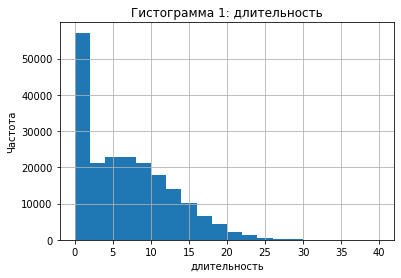

In [35]:
g = 1
myhist(20, calls['duration'], 'длительность',g, (0,40))

Наблюдается явная ошибка регистрации длительности звонка или пропущенный звонок. Посмотрим, какой процент от всех регистрируемых звонков он составляет. Если бы не нулевой всплеск распределение бы имело форму распределения Пуассона. Посмотрим, нет ли нулевых абонентов (с нулем минут разговора) и какой процент нулевые звонки составляют от всех данных.

In [36]:
calls.groupby('user_id')['duration'].agg('sum').sort_values()
calls['user_id'].value_counts(dropna = False)

1377    1760
1168    1692
1375    1560
1453    1440
1196    1240
        ... 
1397      33
1442      28
1373      24
1016      20
1257      14
Name: user_id, Length: 492, dtype: int64

Абонента с нулем звонков нет. 

In [37]:
round(calls.query('duration==0')['duration'].count()/len(calls),2)

0.2

Примерно 20% нулевых звонков из более 20 000. Как писалось выше, тут 2 возможности - либо пропущенные звонки, которые и так не на что не влияют, либо некорректно зарегистрированные данные, но тогда эти данные также не на что не влияют - компании правильно будет не учитывать эти звонки, так как в случае ошибки она понесет репутационные потери. Поэтому удаляем эти данные и рекомендуем фирме проверить механизм регистрации.

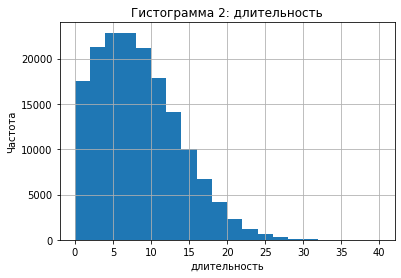

In [38]:
calls = calls.loc[calls['duration'] !=0]
g+=1
myhist(20, calls['duration'], 'длительность',g, (0,40))

Распределение предстало перед нами во всей красе распределения Пуассона. 

Переведем столбец call_date к datetime64. Добавим столбец день и месяц звонка.

In [39]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
print(f"Диапазон наблюдений звонков {calls['call_date'].min()} - {calls['call_date'].max()} ")
calls['month'] = (pd.DatetimeIndex(calls['call_date']).month).astype('int')
calls['day'] = (pd.DatetimeIndex(calls['call_date']).day).astype('int')

Диапазон наблюдений звонков 2018-01-01 00:00:00 - 2018-12-31 00:00:00 


Диапазон согласуется с диапазоном наблюдения за users. Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам, добавим информацию в таблицу df.

In [40]:

m_duration = calls.groupby(['user_id', 'month'])['duration'].agg('sum').reset_index()
df = df.merge(m_duration,on='user_id',how='left')
df['duration'] = df['duration'].fillna(0)

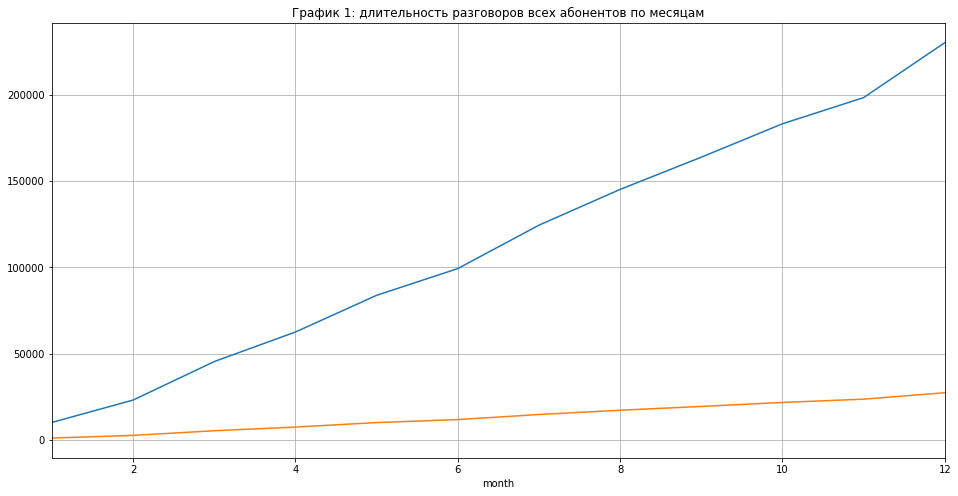

In [41]:
gr = 1
m_duration.groupby('month')['duration'].agg('sum').plot(x='month', y='duration', xlim =(0,15),figsize=(16, 8), title = f'График {gr}: длительность разговоров всех абонентов по месяцам')

calls.groupby('month')['user_id'].agg('count').plot(x='month', y='duration',grid=True)

С увелечением колличества звонков растет и колличество израсходованных минут. Но идет круче, т.е. те, кто звонит чаще и говорит дольше.

### messages

In [42]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [43]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
m_messages = messages.groupby(['user_id', 'month'])['id'].agg('count').reset_index()
m_messages.rename(index=str, columns={"id": "messages_used"}, inplace=True)

df = df.merge(m_messages,on=['user_id', 'month'],how='left')
df['messages_used'] = df['messages_used'].fillna(0)

### internet

In [44]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [45]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
m_internet = internet.groupby(['user_id', 'month'])['mb_used'].agg('sum').reset_index()
df = df.merge(m_internet,on=['user_id', 'month'],how='left')
df['mb_used'] = df['mb_used'].fillna(0)


### tariffs

In [46]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Ошибок не нашлось, ничего переводить не надо. Объединим информацию о трафике в общую таблицу для удобства рассчета.

In [47]:
tariffs.rename(index=str, columns={"tariff_name": "tariff"}, inplace=True)
df = df.merge(tariffs,on='tariff',how='left')
df

,user_id,age,churn_date,city,reg_date,tariff,month,duration,messages_used,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Другой,2018-05-25,ultra,5.0,150.06,22.0,2253.49,1000,30720,3000,1950,150,1,1
1,1000,52,NaT,Другой,2018-05-25,ultra,6.0,158.90,60.0,23233.77,1000,30720,3000,1950,150,1,1
2,1000,52,NaT,Другой,2018-05-25,ultra,7.0,318.80,75.0,14003.64,1000,30720,3000,1950,150,1,1
3,1000,52,NaT,Другой,2018-05-25,ultra,8.0,389.87,81.0,14055.93,1000,30720,3000,1950,150,1,1
4,1000,52,NaT,Другой,2018-05-25,ultra,9.0,440.14,57.0,14568.91,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3171,1498,68,2018-10-25,Другой,2018-07-19,smart,10.0,232.63,42.0,20579.36,50,15360,500,550,200,3,3
3172,1499,35,NaT,Другой,2018-09-27,smart,9.0,64.65,11.0,1845.75,50,15360,500,550,200,3,3
3173,1499,35,NaT,Другой,2018-09-27,smart,10.0,429.91,48.0,17788.51,50,15360,500,550,200,3,3
3174,1499,35,NaT,Другой,2018-09-27,smart,11.0,576.50,59.0,17963.31,50,15360,500,550,200,3,3


Добавим помесячную выручку с каждого пользователя 

In [48]:
not_ink = {'duration':['minutes_included','minutes_not_included'], 'mb_used':['mb_per_month_included','gb_not_included'], 'messages_used':['messages_included','messages_not_included']}
for x,y in not_ink.items():
    if y[1] != 'gb_not_included':
        df[y[1]] =df[x] - df[y[0]]
        df.loc[df[y[1]] < 0,y[1]] = 0
        df[y[1]] = df[y[1]].apply(np.trunc)
    else:
        df[y[1]] = (df[x] - df[y[0]])/1024
        df[y[1]] = df[y[1]].apply(np.trunc) 
        df.loc[df[y[1]] < 0,y[1]] = 0


# rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта), поэтому трафик интернета сверх делим на 1024 и округляем в большую сторону

df['revenue_per_month'] =  df['minutes_not_included']*df['rub_per_minute'] + df['gb_not_included']*df['rub_per_gb'] + df['messages_not_included']*df['rub_per_message'] + df['rub_monthly_fee']


### Вывод
Для дальнейшего анализа мы из таблицы calls удалили звонки длительностью 0. Во всех таблицах перевели дату в формат datetime64. Для каждого клиента мы расписали активность по месяцам и ежемесячные траты.

## Шаг 3. Проанализируйте данные

In [105]:
smart = df.query('tariff == "smart"')
ultra = df.query('tariff == "ultra"')
print(f'пользователей smart: {len(smart)} ultra: {len(ultra)}')

пользователей smart: 2223 ultra: 953


Построим гистограммы использования услуг и помесячной платы.

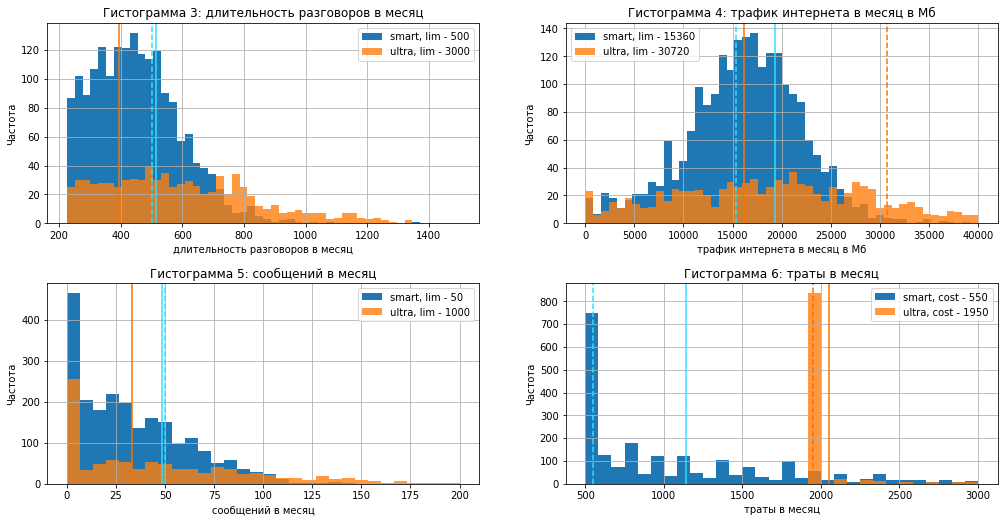

In [49]:
plt.figure(figsize=(16, 8))
plt.subplots_adjust(right=0.95, bottom=0.1, top=0.9, hspace=0.3) 


ax = plt.subplot(221)
g += 1
myhist(50, smart['duration'], 'длительность разговоров в месяц',g, (225,1500))
ultra['duration'].hist(bins = 50, alpha = 0.8,range = (225,1500))
plt.legend(["smart, lim - 500", "ultra, lim - 3000"])
plt.axvline(500, color = '#33DDFF', linestyle = '--')

plt.axvline(smart['duration'].mean(), color = '#FB7200')
plt.axvline(ultra['duration'].mean(), color = '#33DDFF')

ax = plt.subplot(222)
g += 1
myhist(50, smart['mb_used'], 'трафик интернета в месяц в Мб',g, (0,40000))
ultra['mb_used'].hist(bins = 50, alpha = 0.8,range = (0,40000))
plt.legend(["smart, lim - 15360", "ultra, lim - 30720"])
plt.axvline(30720, color = '#FB7200', linestyle = '--')
plt.axvline(15360, color = '#33DDFF', linestyle = '--')
plt.axvline(smart['mb_used'].mean(), color = '#FB7200')
plt.axvline(ultra['mb_used'].mean(), color = '#33DDFF')


ax = plt.subplot(223)
g += 1
myhist(30,smart['messages_used'], 'сообщений в месяц',g, (0,200))
ultra['messages_used'].hist(bins = 30, alpha = 0.8,range = (0,200))
plt.legend(["smart, lim - 50", "ultra, lim - 1000"])
plt.axvline(50, color = '#33DDFF', linestyle = '--')
plt.axvline(smart['messages_used'].mean(), color = '#FB7200')
plt.axvline(ultra['messages_used'].mean(), color = '#33DDFF')

ax = plt.subplot(224)
g += 1
myhist(30, smart['revenue_per_month'], 'траты в месяц',g, (500,3000))
ultra['revenue_per_month'].hist(bins = 30, alpha = 0.8,range = (500,3000))
plt.legend(["smart, cost - 550", "ultra, cost - 1950"])
plt.axvline(1950, color = '#FB7200', linestyle = '--')
plt.axvline(550, color = '#33DDFF', linestyle = '--')
plt.axvline(ultra['revenue_per_month'].mean(), color = '#FB7200')
plt.axvline(smart['revenue_per_month'].mean(), color = '#33DDFF')
plt.show()



Прерывистая линия - лимит, сплошная - среднее.

У smart более "правильное" распределение длительности звонков, выглядещее как распределение Пуассона, потому что пользователей больше. Трафик интернета выглядит, как Гауссовское распределение - видимо, не всех интересует сеть в одинаковой степени.

Многие пользователи не пользуются сообщениями вообще. Средние траты пользователей smart обычно в 2 раза больше стоимости тарифа. ultra в среднем платят чуть больше за связь, чем стоимость их пакета.

In [50]:
def my_proc(part, p100):
    m = round(part / p100 * 100)
    return m

s_d = my_proc(smart.query('duration <= 500')['duration'].count(),len(smart))
s_i = my_proc(smart.query('mb_used <= 15360')['mb_used'].count(),len(smart))
s_m = my_proc(smart.query('messages_used <= 50')['messages_used'].count(),len(smart))
s_r = my_proc(smart.query('revenue_per_month <= 550')['revenue_per_month'].count(),len(smart))

u_d = my_proc(ultra.query('duration <= 3000')['duration'].count(),len(ultra))
u_i = my_proc(ultra.query('mb_used <= 30720')['mb_used'].count(),len(ultra))
u_m = my_proc(ultra.query('messages_used <= 1000')['messages_used'].count(),len(ultra))
u_r = my_proc(ultra.query('revenue_per_month <= 1950')['revenue_per_month'].count(),len(ultra))
print(f'процент укладывющихся в smart - длительность: \
{s_d} %, \
интернет-трафик:\
{s_i} %, \
сообшений:\
{s_m} %, \
ежемесячную плату:\
{s_r} % \n\
процент укладывющихся в ultra - длительность: \
{u_d} %, \
интернет-трафик:\
{u_i} %, \
сообшений:\
{u_m} %, \
ежемесячную плату:\
{u_r} %')


процент укладывющихся в smart - длительность: 72 %, интернет-трафик:42 %, сообшений:75 %, ежемесячную плату:30 % 
процент укладывющихся в ultra - длительность: 100 %, интернет-трафик:87 %, сообшений:100 %, ежемесячную плату:88 %


В 2018-м году особенно тяжело уложиться в интернет-трафик. Пользователи использую еще какие-то услуги, кроме изучаемых (видно по ситуациеи с ultra). Но процент использования других услуг в нашей выборке незначителен.

В ultra укладываются почти все пользователи, smart докупает активно интернет-трафик.

In [51]:
df.describe()

,user_id,age,month,duration,messages_used,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_not_included,gb_not_included,messages_not_included,revenue_per_month
count,3176.000000,3176.000000,3168.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000,3176.000000
mean,1251.542191,46.672859,8.317551,430.979232,37.890113,17142.146943,335.059824,19968.967254,1250.157431,970.088161,184.996851,2.399874,2.399874,21.427582,1.884446,4.070529,1413.411839
std,144.597802,16.566365,2.907181,225.103579,35.480888,7594.265024,435.439352,7040.366790,1145.893032,641.700098,22.917861,0.916714,0.916714,61.259138,3.178897,11.569117,769.092888
min,1000.000000,18.000000,1.000000,0.000000,0.000000,0.000000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,0.000000,0.000000,0.000000,550.000000
25%,1126.000000,32.000000,6.000000,273.425000,9.000000,12453.752500,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,0.000000,0.000000,0.000000,612.250000
50%,1254.000000,46.000000,9.000000,420.615000,30.000000,16895.320000,50.000000,15360.000000,500.000000,550.000000,200.000000,3.000000,3.000000,0.000000,0.000000,0.000000,1359.000000
75%,1379.000000,62.000000,11.000000,558.207500,57.000000,21388.282500,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,0.000000,3.000000,0.000000,1950.000000
max,1499.000000,75.000000,12.000000,1578.060000,224.000000,49745.690000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,854.000000,22.000000,93.000000,6411.000000


In [89]:
def plot(x, y=None, title=None, x_label=None, y_label=None, kind='plot', **kwargs):
    f, n = {
        'plot': (plt.plot, 2),
        'line': (plt.plot, 2),
        'scatter': (plt.scatter, 2),
        'hist': (plt.hist, 1),
        'dist': (sns.distplot, 1),
        'box': (sns.boxplot, 1),
        'violin': (sns.violinplot, 1),
        'reg': (sns.regplot, 2),
        'lm': (sns.lmplot, 2),
        
    }[kind]
    f(x, **kwargs) if n == 1 else f(x, y, **kwargs)
    ax = kwargs['ax'] if 'ax' in kwargs else plt.gca()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    return ax

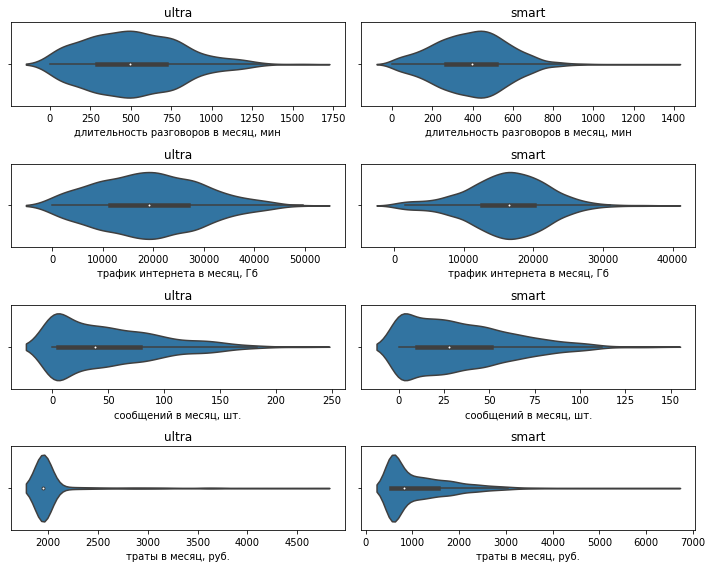

In [103]:
var_dict = {'длительность разговоров в месяц, мин': 'duration','трафик интернета в месяц, Гб':'mb_used','сообщений в месяц, шт.':'messages_used', 'траты в месяц, руб.':'revenue_per_month'}
f, axs = plt.subplots(4, 2, figsize=(10, 8) )
axs = axs.flatten()
f.tight_layout()
i=0
for ru,c in var_dict.items():   
    plot(df.loc[df['tariff'] == 'ultra'][c], x_label=ru, kind='violin', ax=axs[i])
    axs[i].set_title('ultra')
    plot(df.loc[df['tariff'] == 'smart'][c], x_label=ru, kind='violin', ax=axs[i+1])
    axs[i+1].set_title('smart')
    i+=2
plt.tight_layout()   

На графиках видно, что медиана длительности разговоров в месяц у ultra около 500, smart - 400, трафик интернета в месяц примерно одинаков, сообщений больше у ультра и по медиане и хвост длинее. Траты же в среднем в 2 раза больше у ultra.

### Вывод
Поведение клиентов оператора, исходя из выборки в 2х тарифах различается. В основном ultra укладывается в пакет, smart - нет. У ultra более разнообразное поведение клиентов - дисперсия выше. Но в среднем им всего требуется больше. И платят они за это в 2 раза больше. Ближе всего значение потребления трафика интернета  - в среднем пользователи ultra посмотрели на 2 фильма больше в приемлемом качестве (если переводить в эти ед.изм.)

## Шаг 4. Проверьте гипотезы
Выдвигаем гипотезу, о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Используем гипотезу о равенстве средних для зависимых (парных) выборок. Парная выборка означает, что мы измеряем некоторую переменную для одних и тех же единиц. В нашем распоряжении измерения для пользователей одного оператора на 2-х тарифах.

Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» равна между собой. Альтернативная гипотеза: средная выручка пользователей тарифа «Ультра» больше тарифа «Смарт» (т.к. мы узнали, что в среднем это так).

In [32]:
len(df.query('tariff == "ultra"'))


953

In [33]:
revenue_smart = df.query('tariff == "smart"')['revenue_per_month'].sample(n=len(df.query('tariff == "ultra"'))) 
revenue_ultra = df.query('tariff == "ultra"')['revenue_per_month']

revenue_smart_m = round(revenue_smart.mean(),2)
revenue_ultra_m =round(revenue_ultra.mean(),2)

alpha = .05 # критический уровень статистической значимости


results = st.ttest_rel(revenue_smart, revenue_ultra)

print('p-значение: ', results.pvalue)

print('cредние траты в месяц smart: ',revenue_smart_m)
print('cредние траты в месяц ultra: ',revenue_ultra_m)

alpha = .05# ваш код: задайте критический уровень статистической значимости

results =  st.ttest_rel(revenue_smart, revenue_ultra)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  3.8347161341330393e-171
cредние траты в месяц smart:  1158.81
cредние траты в месяц ultra:  2050.58
p-значение: 3.8347161341330393e-171
Отвергаем нулевую гипотезу


Нулевую гипотезу отвергли, а среднее траты ultra больше средних трат smart, значит первое приносит больше денег.

Проверим гипотезу, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза: средняя выручка пользователей из Москвы и других городов равна между собой. 

Альтернативная гипотеза: средная выручка с москвичей больше других городов (т.к. столичные ребята живут богато).

In [34]:
revenue_msk = df.query('city == "Москва"')['revenue_per_month']
revenue_dif = df.query('city != "Москва"')['revenue_per_month'].sample(n=len( df.query('city == "Москва"')['revenue_per_month'])) 

revenue_msk_m = revenue_msk.mean()
revenue_dif_m =revenue_dif.mean()

alpha = .05 # критический уровень статистической значимости


results = st.ttest_rel(revenue_dif, revenue_msk)

print('p-значение: ', results.pvalue)

print('cредние траты в месяц Москва: ',revenue_msk_m)
print('cредние траты в месяц другие города: ',revenue_dif_m)

alpha = .05# ваш код: задайте критический уровень статистической значимости

results =  st.ttest_rel(revenue_dif, revenue_msk)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.7391522642199426
cредние траты в месяц Москва:  1445.0393442622951
cредние траты в месяц другие города:  1430.272131147541
p-значение: 0.7391522642199426
Не получилось отвергнуть нулевую гипотезу


Москва не тратит на связь больше, чем другие города. 

Интересно посмотреть, не чаше ли отключаются с одного из тарифов.

In [35]:
otkl_smart_m = my_proc(smart.query('churn_date.notnull()')['churn_date'].count(), len(smart))
otkl_ultra_m = my_proc(ultra.query('churn_date.notnull()')['churn_date'].count(), len(ultra))


print(f'в среднем отключаются от smart: {otkl_smart_m} %')
print(f'в среднем отключаются от ultra: {otkl_ultra_m} %')

print('на сколько процентов ultra приносит больше денег, чем smart: ', my_proc(revenue_ultra_m, revenue_smart_m +revenue_ultra_m), ' %')
print('сколько нужно пользователей smart, чтобы заменить собой одного пользователя ultra по выручке: ', round(revenue_ultra_m/revenue_smart_m,2), ' чел.')
print('на сколько популярнее smart, чем ultra: ', my_proc(len(users.query('tariff == "smart"')),len(users)), ' %')



в среднем отключаются от smart: 5 %
в среднем отключаются от ultra: 8 %
на сколько процентов ultra приносит больше денег, чем smart:  64  %
сколько нужно пользователей smart, чтобы заменить собой одного пользователя ultra по выручке:  1.77  чел.
на сколько популярнее smart, чем ultra:  70  %


<div class="alert alert-block alert-success">
Комментарий ревьюера v. 1:
    
Дополнительные материалы: https://www.analyticsvidhya.com/blog/2019/09/everything-know-about-p-value-from-scratch-data-science/, https://ocw.mit.edu/courses/mathematics/18-443-statistics-for-applications-fall-2006/lecture-notes/lecture13.pdf 
</div>

### Вывод
Пользователи ultra приносят больше денег, чем пользователи smart. Уходят с тарифа ultra чуть чаше, а smart много популярнее. Москвичи так же бережливы, как и жители замкадья.

## Общий вывод

Анализируя полученные данные мы удалили звонки длительностью в ноль минут. Во всех таблицах перевели дату в формат datetime64. Для каждого клиента мы расписали активность по месяцам и ежемесячные траты.

Поведение клиентов оператора, исходя из выборки по тарифам различается. В основном ultra укладывается в пакет, smart - нет. У ultra более разнообразное поведение клиентов - дисперсия выше. Но в среднем им всего требуется больше. И платят они за это в 2 раза больше. 

Пользователи ultra по отдельности приносят больше денег, чем пользователи smart. Уходят с тарифа ultra чуть чаше, а smart более чем в 2 раза популярнее. Москвичи так же бережливы, как и жители других городов.

<b>Вывод: рекомендуем рекламировать smart во всех городах России.</b> Он привлечет больше пользователей, как минимум в 2 раза больше. При этом 2 пользоватяля smart принесут прибыли больше, чем 1 ultra